# Report on Multi-Class Classifiers Using NSL-KDD Dataset

## Section 1 - Comparing Algorithms and Evaluation Metrics

I will first explore the performance of 3 different algorithms (Random Forest, linear SVC, and logistic regression) when using all the attributes as features, with regards to different evaluation metrics. I have chosen these 3 algorithms as linear SVC and logistic regressions are both linear models that aare cost-effective and offer high intrepretability, while random forests relies on bootstrap aggregating to create an ensemble of decision trees that offer improved performance over a singular decision tree. If these models do not offer viable performance, I would consider other costlier but better models (such as SVC with RBF kernel) to implement instead.

In [1]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV


train_set = pd.read_csv('../../KDDTrain+.csv', header=None)
field_names = pd.read_csv('../../Field Names.csv', header=None)

# Adding headers for last 2 columns as they arrived unlabeled in the Field Names list
# Unclear what the last column of data represents
field_names_extension = pd.DataFrame([['attack_type', 'symbolic'],['??','continuous']])
field_names = field_names.append(field_names_extension, ignore_index=True)

# Dropping column which signifies if Continuous or Symbolic Attribute
field_names = field_names.drop(columns=[1])

# Adding headers to training set
dataframe_headers = field_names[0].tolist()
train_set.columns = dataframe_headers

cols = train_set.columns.tolist()
cols = cols[-2:-1] + cols[:-2] + cols[-1:]  #Re-ordering columns so that 'attack_type' is left-most column
train_set = train_set[cols]

In order to achieve such exploration, I would have to enumerate the categoricals (service, protocol type, and flag) 

In [2]:
# ENUMERATING SERVICE TYPE

service_list = train_set['service'].unique()

# Try except to prevent overwrites in multiple iterations which would affect the results
try:
    service_list2
except NameError:
    service_list2 = copy.deepcopy(service_list)    
    svc_enum_data = {'service': service_list}
    service_enumerations = pd.DataFrame(data = svc_enum_data)
    
enumerated_service_list = [x for x in range(len(service_list))]

train_set = train_set.replace(service_list, enumerated_service_list)

# ENUMERATING PROTOCOL TYPE

prot_list = train_set['protocol_type'].unique()

try:
    prot_list2
except NameError:
    prot_list2 = copy.deepcopy(prot_list)    
    prot_enum_data = {'protocol_type': prot_list}
    prot_enumerations = pd.DataFrame(data=prot_enum_data)
    
enumerated_prot_list = [x for x in range(len(prot_list))]

train_set = train_set.replace(prot_list,enumerated_prot_list)

# ENUMERATING FLAG TYPE

flag_list = train_set['flag'].unique()

try:
    flag_list2
except NameError:
    flag_list2 = copy.deepcopy(flag_list)    
    flag_enum_data = {'flag': flag_list}
    flag_enumerations = pd.DataFrame(data=flag_enum_data)
    
enumerated_flag_list = [x for x in range(len(flag_list))]

train_set = train_set.replace(flag_list,enumerated_flag_list)


Importing Test Set

In [3]:
test_set = pd.read_csv('../../KDDTest+.csv', header=None)
test_set.columns = dataframe_headers

test_set = test_set[cols]

test_set = test_set.replace(service_list2,enumerated_service_list)
test_set['service'] = test_set['service'].apply(lambda x: '-1' if type(x) is str else x)

test_set = test_set.replace(prot_list2, enumerated_prot_list)
test_set['protocol_type'] = test_set['protocol_type'].apply(lambda x: '-1' if type(x) is str else x)

test_set = test_set.replace(flag_list2, enumerated_flag_list)
test_set['flag'] = test_set['flag'].apply(lambda x: '-1' if type(x) is str else x)

### Combining Test and Train to perform Stratified Sampling
Stratified sampling is used so as to ensure the fairness in the distribution. This is to ensure that both the training and test set is representative of the population, and reduce biases involved that may skew our results

In [4]:
combined_table = train_set.append(test_set, ignore_index=True)
combined_table_features = combined_table.drop(columns=['attack_type'])
combined_table_target = combined_table['attack_type']


In [5]:
train_features, test_features, train_target, test_target = train_test_split(combined_table_features, combined_table_target, test_size=0.1, shuffle=True, stratify=combined_table_target)

Setting up the classifiers:

In [6]:
svc_clf_lin = LinearSVC()
svc_clf_lin.fit(train_features, train_target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [7]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_features, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Testing The Classifiers 
Micro is used due to class imbalance in multi class classification, and can be compared with the Weighted results for comparison

In [9]:
result_df_columns = ['Classifier', 'Accuracy', 'Precision (Micro)', 'Precision (Weighted)', 'Recall (Micro)', 'Recall (Weighted)', 'F-1 (Micro)', 'F1 (Weighted)']
clf_cmp_dataframe = pd.DataFrame(columns=result_df_columns)


In [10]:
%%capture --no-display

# SVC linear
svc_lin_pred_list = svc_clf_lin.predict(test_features)
svc_lin_acc = accuracy_score(test_target, svc_lin_pred_list)
svc_lin_prec_mic = precision_score(test_target, svc_lin_pred_list, average='micro')
svc_lin_prec_mac = precision_score(test_target, svc_lin_pred_list, average='weighted')
svc_lin_rec_mic = recall_score(test_target, svc_lin_pred_list, average='micro')
svc_lin_rec_mac = recall_score(test_target, svc_lin_pred_list, average='weighted')
svc_lin_f1_mic = f1_score(test_target, svc_lin_pred_list, average='micro')
svc_lin_f1_mac = f1_score(test_target, svc_lin_pred_list, average='weighted')

svc_lin_res = ["SVC Linear", svc_lin_acc, svc_lin_prec_mic, svc_lin_prec_mac, svc_lin_rec_mic, svc_lin_rec_mac, svc_lin_f1_mic, svc_lin_f1_mac]
svc_lin_df = pd.DataFrame([svc_lin_res], columns=result_df_columns)

clf_cmp_dataframe = clf_cmp_dataframe.append(svc_lin_df, ignore_index=True)

In [11]:
# RF

rf_pred_list = rf_clf.predict(test_features)
rf_acc = accuracy_score(test_target, rf_pred_list)
rf_prec_mic = precision_score(test_target, rf_pred_list, average='micro')
rf_prec_mac = precision_score(test_target, rf_pred_list, average='weighted')
rf_rec_mic = recall_score(test_target, rf_pred_list, average='micro')
rf_rec_mac = recall_score(test_target, rf_pred_list, average='weighted')
rf_f1_mic = f1_score(test_target, rf_pred_list, average='micro')
rf_f1_mac = f1_score(test_target, rf_pred_list, average='weighted')

rf_res = ["RF", rf_acc, rf_prec_mic, rf_prec_mac, rf_rec_mic, rf_rec_mac, rf_f1_mic, rf_f1_mac]
rf_df = pd.DataFrame([rf_res], columns=result_df_columns)

clf_cmp_dataframe = clf_cmp_dataframe.append(rf_df, ignore_index=True)

In [12]:
# LR

lr_pred_list = lr_clf.predict(test_features)
lr_acc = accuracy_score(test_target, lr_pred_list)
lr_prec_mic = precision_score(test_target, lr_pred_list, average='micro')
lr_prec_mac = precision_score(test_target, lr_pred_list, average='weighted')
lr_rec_mic = recall_score(test_target, lr_pred_list, average='micro')
lr_rec_mac = recall_score(test_target, lr_pred_list, average='weighted')
lr_f1_mic = f1_score(test_target, lr_pred_list, average='micro')
lr_f1_mac = f1_score(test_target, lr_pred_list, average='weighted')

lr_res = ["LR", lr_acc, lr_prec_mic, lr_prec_mac, lr_rec_mic, lr_rec_mac, lr_f1_mic, lr_f1_mac]
lr_df = pd.DataFrame([lr_res], columns=result_df_columns)

clf_cmp_dataframe = clf_cmp_dataframe.append(lr_df, ignore_index=True)

In [13]:
clf_cmp_dataframe

,Classifier,Accuracy,Precision (Micro),Precision (Weighted),Recall (Micro),Recall (Weighted),F-1 (Micro),F1 (Weighted)
0,SVC Linear,0.885807,0.885807,0.932365,0.885807,0.885807,0.885807,0.904054
1,RF,0.997105,0.997105,0.996858,0.997105,0.997105,0.997105,0.996937
2,LR,0.845206,0.845206,0.784975,0.845206,0.845206,0.845206,0.802758


## Section 2 - Evaluating Results


### Model to Choose

As seen from the data above, the Random Forest model performs better than the other models in every category. This could be possible due to the fact that this dataset is a multi-class problem, which is not equally distributed amongst every class. Having an ensemble of decision trees to form a Random Forest allows for different cases to be explored, and build a better model to predict by. 



### Metrics

#### Precision and Recall Tradeoff  (Using a Precision Recall Curve)
When evaluating models, a common dilemma is the trade-off between precision and recall. Ideally, we would want high precision and high recall, but at times one may be boosted at the expense of the other. From a binary context, precision represents the proportion of true positives out of all the points classified as positive (true and false positives), while recall represents the proportion of true positives out of all the points that should be positive (true positives and false negatives). As such, high precision means that there are very few false positives, while high recall means most of the positives were correctly identified. However, by considering only precision or only recall, models can be created to circumvent issues to falsely project a good model. For example, by identifying every single data point as positive, there would be a perfect recall, at the expense of many false positives and low precision. Likewise, by not identifying a single positive, the inverse happens.

With a precision and recall curve, we can try to identify a specific point where there is a sufficient balance between the precision and recall, where this threshold allows for suitably high precision and recall. Something similar can also be achieved using a Receiver Operating Characteristic Curve, by plotting the True Positive Rate against the False Positive Rate. In order to simplify the process, I would be considered a binary classifier instead, where the comparison would be between 'normal' and all other attack types.

In [46]:
# Turning attack types into binary

train_target_bin = train_target.apply(lambda x: 'not normal' if x != 'normal' else x)
test_target_bin = test_target.apply(lambda x: 0 if x != 'normal' else 1)

# Creating a new RF classier

rf_binary_clf = RandomForestClassifier()
rf_binary_clf.fit(train_features, train_target_bin)
test_score_bin = rf_binary_clf.predict_proba(test_features)

In [75]:
from sklearn.metrics import average_precision_score

norm_probas = []
for x in range(len(test_score_bin)):
    norm_probas = norm_probas + [test_score_bin[x][0]]

avg_precision_score = average_precision_score(test_target_bin, norm_probas) 
print avg_precision_score

0.9999347972481015


Text(0.5,1,'2-class Precision-Recall curve: AP=1.00')

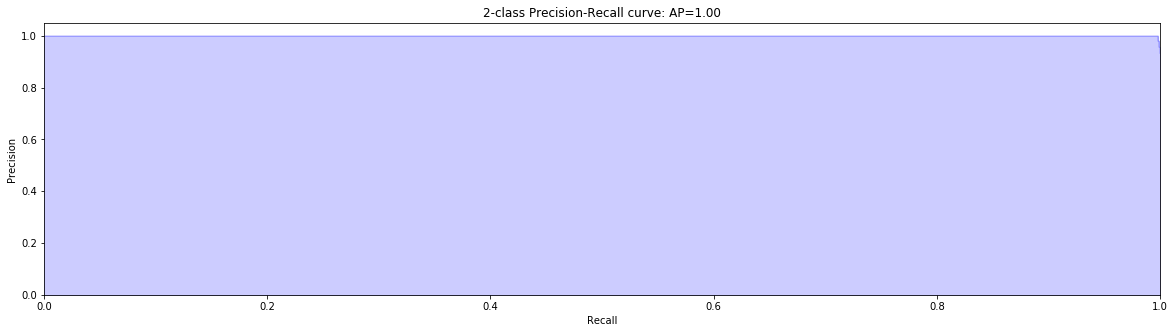

In [76]:
# Following scikit-learn tutorial

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, k = precision_recall_curve(test_target_bin, norm_probas)

plt.figure(figsize=(20,5))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          avg_precision_score))

In [88]:
for i in range(len(k)):
    if precision[i] == 1:
        print("k: " + str(k[i]))
        print("Precision: " + str(precision[i]))
        print("Recall: " + str(recall[i]))
        break

k: 0.8891891891891891
Precision: 1.0
Recall: 0.9890994030625486


#### Conclusion
From the curve plotted above, I have chosen a k-value of 0.889 , which offers a precision score of 1.0 and a recall score of 0.989 . However, this curve has proven to be somewhat trivial, as the model has performed too well. This has led to high precision and recall at almost every point. As such, there is not much trade-off to be made, as the precision and recall would be high no matter which point I choose.

In a less ideal scenario, I would choose a score skewed towards recall over precision, due to the purpose of the classifier. As the data involved pertains to potential attacks on a network system, it is important to take necessary precautions to mitigate any potential damage. In such a situation, it may be beneficial to allow for more False Positives as compared to False Negatives. This is to ensure that any potential risks can be explored, where it is better to realise that there is nothing wrong as compared to not detecting an attack, and realising when it is too late. Hence, my choice would be skewed towards recall, where the proportions of False Negatives are as low as possible.

### Cross-Validation Using K-Fold CV

In order to ensure that the results obtained were representative, I have used K-Folds cross-validation to check if the results obtained are similar using different folds of the data instead.
Cross-validation is necessary to validate the model on other sets of data than the training set to ensure as little bias, and K-folds cross-validation is one of the more popular ways to do so.

In [14]:
kf = KFold(n_splits=10, shuffle=True)
rf2_clf = RandomForestClassifier()

np.mean(cross_val_score(rf2_clf, combined_table_features, combined_table_target, cv=kf))

0.9969363515816496

The value obtained is very similar to the one above, which validates the appropriateness and accuracy of the RF classifier on this dataset.

## Section 3 - Iterations to Improve Model

### Scaling Data/ Pre-Processing


#### Scaling
I have chosen a MinMaxScaler to use, instead of the similar MaxAbsScaler. MinMaxScaler scales all features in the range [0,1], which helps the performance of certain models.

In [15]:
scaler = preprocessing.MinMaxScaler()

train_feats_scaled = scaler.fit_transform(train_features.values)
train_features.iloc[:,:] = train_feats_scaled

test_feats_scaled = scaler.fit_transform(test_features.values)
test_features.iloc[:,:] = test_feats_scaled

rf_scaler_clf = RandomForestClassifier()

rf_scaler_clf.fit(train_features, train_target)
rf_pred_list_scaler = rf_scaler_clf.predict(test_features)

recall_score(test_target, rf_pred_list_scaler, average='weighted')

0.9931322380824131

Despite scaling being supposed to help us pefrom better, this random classifier has ended up doing worse than the original in Section 1. Hence, this model can be discarded as it isn't as useful as the other. This is due to the fact that such scaling should not really impact decision-based tree models, as they consider one variable at a time. Random Forest is implemented via multiple decision trees, hence the scaling does not have much of an impact.

### Using Binary Classification on a Multi-Class Model

As the classifier's aim is to detect attacks from normal network accesses, we can modify the evaluation metrics to treat it as a binary classifier. This looser definition would allow for us to focus on attacks being identified, rather than the type of attack. This still serves our main purpose, where the broad goal is to distinguish attacks from normal accesses, to minimise the risks of attacks going undetected.

In [16]:
# Calculating Recall of non-normal

size_test_list = len(rf_pred_list)
n_normal = 0
retrieved_and_relevant = 0

for x in range(size_test_list):
    if test_target.values[x] == 'normal':
        n_normal = n_normal + 1
    elif rf_pred_list[x] != 'normal':
        retrieved_and_relevant = retrieved_and_relevant + 1

relevant = size_test_list - n_normal
binary_recall = retrieved_and_relevant / float(relevant)
print(binary_recall)

0.998600615729


The value above shows that the multi-class model of the RF can be adopted to be treated as a binary classifier, as there is a high recall which minimises the number of attacks that go undetected. Albeit some of the attacks may be wrongly identified as another form of attack, the classifier would still flag them for investigation.

### Using Grid Search CV to Find Best RF Hyper-parameters
While the default RF classifier performed extremely well already, I will use Grid Search CV to see if it can improve on the default model above. The default uses n_estimators at 10, and max_depth at None. These are the 2 hyper-parameters which I will be varying in order to observe the difference it has on the results.

In [17]:
parameters = {'n_estimators':[10,50,100,200], 'max_depth':[None,3,5,10,15,20,25,30,35,40]}
rf_clf3 = RandomForestClassifier()
cv_clf_2 = GridSearchCV(rf_clf3, parameters)
cv_clf_2.fit(train_features, train_target)

print(cv_clf_2.best_params_)
print(cv_clf_2.best_score_)

{'n_estimators': 200, 'max_depth': 30}
0.9963191285611683


The result above shows a marginal gain in our model when we tweak the hyper-parameters passed into the Random Forest classifier. Having said that, a marginal gain is still an improvement that we can adopt to better our choices.

## Section 4 - Limitations and Other Considerations

1) Imbalanced Dataset : 
    The data set does not reflect the true nature of how network attacks take place, as the data represents close to a 50/50 split between "normal" and attacks. This would signify more of a binary or multi-class classifier, rather than an anomaly detector. In reality, the majority of network traffic should be "normal", which makes it harder for a true classifier to be able to be trained to do such detections of attack.
    
2) Clean Dataset :
    The data set also contains clean data, where every field is filled-in. This does not accurately reflect real-life scenarios, where the data may have to undergo major pre-processing before sense can be made of it. The data also came in with mostly all the features labelled, which aids manual feature selection/creation.
    
3) Academic Dataset :
    In addition to the points above about the dataset, it must also be noted that it is an academic dataset, that has been well-researched and explored previously. Even without any domain knowledge, the abundance of academic reports available online aided my ability to make better and well-informed decisions in terms of models to run, and what to expect.

4) Choice of models :
    In Section 1, I only considered Linear SVC, Random Forest, and Logistic Regressions, and this could have limited my results by not choosing other models to run as well. However, the costs of running more expensive models would not be worth the marginal gains over the results the Random Forest already obtained. The Linear SVC took 13 mins to fit and train the model, and this is already a lot quicker than if I did a SVC with a linear kernel instead. Hence, possibly better models such as SVC with RBF kernel and Deep Neural Networks were not considered in my exploration.

5) Lack of Further Iterations :
    Having found in Section 1 that Random Forest performs a fair bit better than Linear SVC and Logistic Regression, I chose to focus only on Random Forest in further iterations. Perhaps with further tweaking of the other models, improvements could have been found in the other models to become comparable with the Random Forest ones. Due to a lack of time and the costs of running GridSearchCV on models such as Linear SVC, I assumed that Random Forest would be the best model still, as it was already close to 100%.

6) Ordinality Introduced in Enumeration :
    When enumerating the categoricals in order to give them numerical values for the classifiers, a false ordinality was introduced in those features which may skew the result. The other option would be to use scikit-learn's one hot encoding, or numpy.eye, which would introduce the curse of dimensionality instead. 
    
7) Feature Engineering :
    As the results obtained via the Random Forest is already very good, there is little room for feature engineering, be it selection or creation, to improve the model. This might not be the case in other datasets, where methods such as recursive feature selection can be used to rank features. Other aspects of feature selection, such as correlation feature selection, or using the filter or wrapper method, can also be considered in other cases. Manual analysing and/or domain knowledge in other cases may also aid feature creation based on the data given.

## Section 5 - Conclusion

In conclusion, I've found that Random Forest outperforms both the Linear SVC and Logistic Regression in creating a Multi-Class classifier to distinguish attacks in the NSL-KDD dataset. Through further iterations, there seemed to be only marginal gains as compared to the default model, as the default model had already performed really well (99.5%). It must also be noted that due to time and costs, other potentially better models such as the SVC with a RBF kernel were not tested. Given how well the default Random Forest has done though, it would suffice to just adopt it as the go-to model for this dataset.